## BBC Experiment [Part 4 - Basic Segmentation Bro]

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
path=Path('../data/bbc_train')

In [5]:
path.ls()

[PosixPath('../data/bbc_train/train.json'),
 PosixPath('../data/bbc_train/train_classification_labels.csv'),
 PosixPath('../data/bbc_train/.DS_Store'),
 PosixPath('../data/bbc_train/train_masks'),
 PosixPath('../data/bbc_train/train')]

In [6]:
fnames = get_image_files(path/'train')
fnames[:3]

[PosixPath('../data/bbc_train/train/P2050886.jpg'),
 PosixPath('../data/bbc_train/train/P2050729.jpg'),
 PosixPath('../data/bbc_train/train/P2050513.jpg')]

In [7]:
lbl_names = get_image_files(path/'train_masks')
lbl_names[:3]

[PosixPath('../data/bbc_train/train_masks/P2050393.png'),
 PosixPath('../data/bbc_train/train_masks/P2050807.png'),
 PosixPath('../data/bbc_train/train_masks/P2050940.png')]

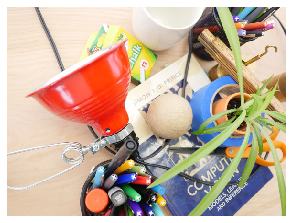

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
def get_y_fn(x): return path/'train_masks'/(x.stem + '.png')
classes = array(['background', 'brick', 'ball', 'cylinder'])

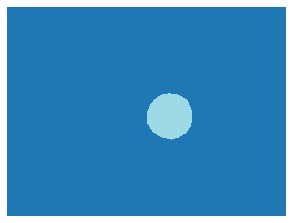

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
unique(mask.data)

array([0, 2])

In [12]:
src = (SegmentationItemList.from_folder(path/'train')
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=classes))

In [13]:
data = (src.transform(get_transforms(), tfm_y=True, size=(256,256))
        .databunch(bs=16)
        .normalize(imagenet_stats))

In [14]:
data

ImageDataBunch;

Train: LabelList (754 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/bbc_train/train;

Valid: LabelList (188 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/bbc_train/train;

Test: None

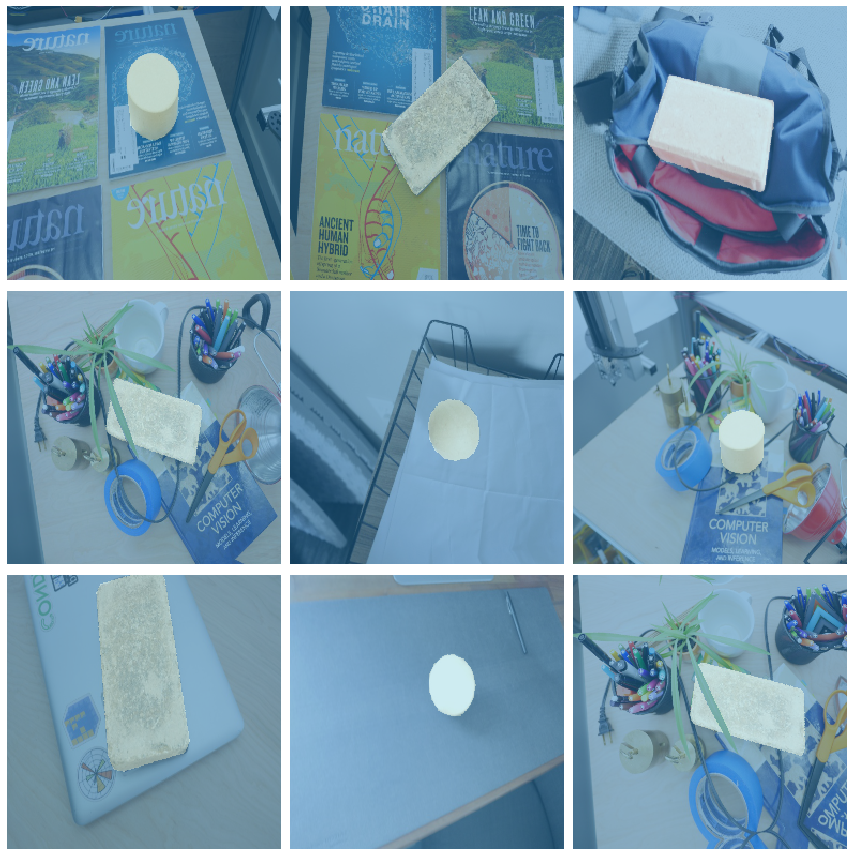

In [15]:
data.show_batch(3, figsize=(12,12))

In [16]:
x,y=data.one_batch()

In [17]:
y.shape, y.unique()

(torch.Size([16, 1, 256, 256]), tensor([0, 1, 2, 3]))

- Ok, I think I may have found the problem - saving mask values as 0, 32, 64, 96 may be where I'm getting into trouble...

In [20]:
learn=cnn_learner(data, models.resnet18)

In [21]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

- BatchNorm2d          [512, 8, 8]
- How can we build this up back to a full image?
- In my lecture, I should be able to borrow some from my GAN lecture on **transposed convolutions**: https://github.com/stephencwelch/dl-workshop/blob/master/generative_adversarial_networks/Generative%20Adversarial%20Networks.ipynb


In [18]:
def conv_trans(ni, nf, ks = 4, stride = 2, padding = 1):
    return nn.Sequential(
        nn.ConvTranspose2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding = padding), 
        nn.ReLU(inplace = True), 
        nn.BatchNorm2d(nf))

In [19]:
custom_head=nn.Sequential(conv_trans(512, 256))

In [44]:
learn=cnn_learner(data, models.resnet18, custom_head=custom_head)

In [45]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

In [20]:
custom_head=nn.Sequential(conv_trans(512, 256), 
                          conv_trans(256, 128),
                          conv_trans(128, 64),
                          conv_trans(64, 32), 
                          nn.ConvTranspose2d(32, 4, kernel_size=4, bias=False, stride=2, padding = 1))

In [21]:
learn=cnn_learner(data, models.resnet18, custom_head=custom_head, metrics=accuracy_thresh)

In [23]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

- Sweet! 
- I guess that I need like a loss function and performance metric now?

In [24]:
x,y =learn.data.one_batch()

In [25]:
x.shape, y.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 1, 256, 256]))

In [26]:
yhat=learn.model(x.to('cuda'))

In [27]:
yhat.shape

torch.Size([16, 4, 256, 256])

In [28]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [29]:
learn.metrics

[<function fastai.metrics.accuracy_thresh(y_pred: torch.Tensor, y_true: torch.Tensor, thresh: float = 0.5, sigmoid: bool = True) -> <function NewType.<locals>.new_type at 0x7fe3a4824ae8>>]

In [59]:
learn=cnn_learner(data, models.resnet18, custom_head=custom_head, metrics=accuracy_thresh)

In [60]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.365061,0.176473,0.712467,00:14


In [55]:
learn.freeze()

In [56]:
learn.lr_find()

Exception in thread Thread-38:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 21, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/ubuntu/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 284, in rebuild_storage_fd
    fd = df.detach()
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

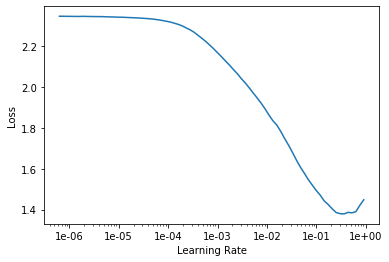

In [25]:
learn.recorder.plot()

In [26]:
lr=1e-2

In [27]:
learn.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.953213,0.249888,0.716352,00:14
1,0.385281,0.112761,0.710685,00:13
2,0.211050,0.092191,0.713261,00:14
3,0.135966,0.082128,0.710093,00:14


In [28]:
learn.unfreeze()

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


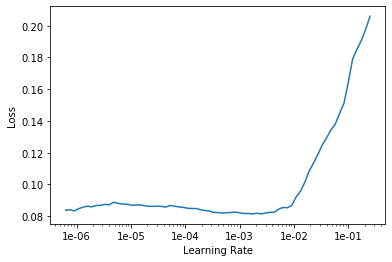

In [30]:
learn.recorder.plot()

In [31]:
lr=1e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.085229,0.072972,0.709921,00:15
1,0.077666,0.060445,0.711956,00:14
2,0.070179,0.050847,0.712263,00:14
3,0.062345,0.046804,0.714087,00:14
4,0.056862,0.042580,0.712248,00:15
5,0.053112,0.040225,0.714211,00:15
6,0.049150,0.039492,0.713903,00:15
7,0.048288,0.039054,0.714248,00:15


In [33]:
preds=learn.predict(learn.data.valid_ds[0][0])

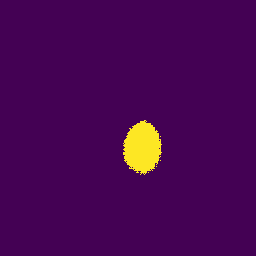

In [36]:
preds[0]

In [39]:
preds[1].shape, preds[2].shape

(torch.Size([1, 256, 256]), torch.Size([4, 256, 256]))

In [41]:
# learn.show_results()

- I'm still not really sure why we can just do accuracy?
- Perhaps if I hadded a softmax or something...It's just an argmax though right, on the accuracy computation?

In [42]:
denorm=learn.data.denorm

In [43]:
with torch.no_grad():
    x,y = next(iter(learn.data.valid_dl))
    yhat = to_np(learn.model(x))
    x=denorm(x)

In [44]:
x.shape, y.shape, yhat.shape

(torch.Size([16, 3, 256, 256]),
 torch.Size([16, 1, 256, 256]),
 (16, 4, 256, 256))

In [45]:
yhat=yhat.argmax(1)

In [46]:
def blend_image_mask(im, mask, alpha=0.7):
    im_mask=np.zeros((im.shape[1], im.shape[2], 3), dtype='float32')
    for j in range(3): im_mask[:,:,j]=im.mean(axis=0)
    for j in range(1, 4):
        im_mask[mask==j] = alpha*im_mask[mask==j] + (1-alpha)*np.array([float(i==(j-1)) for i in range(3)])
    return im_mask

In [50]:
def make_legend():
    custom_lines = [Line2D([0], [0], color='r', lw=2, alpha=0.5),
                    Line2D([0], [0], color='g', lw=2, alpha=0.5),
                    Line2D([0], [0], color='b', lw=2, alpha=0.5)]

    legend(custom_lines, ['Brick', 'Ball', 'Cylinder'])

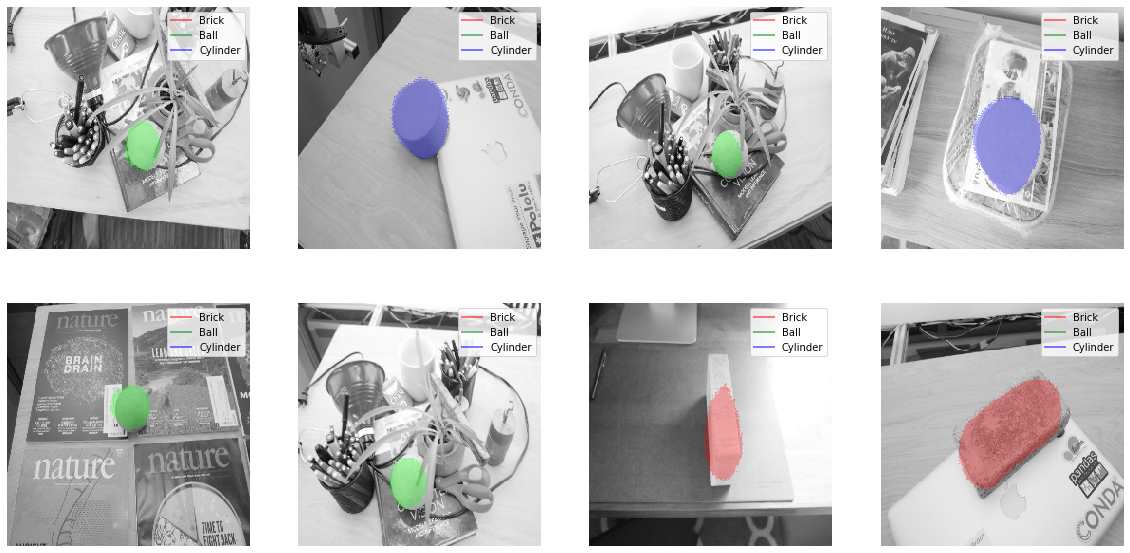

In [53]:
fig=figure(0, (20, 10))

for i in range(8):
    fig.add_subplot(2,4,i+1)
    im_mask=blend_image_mask(x[i], yhat[i])
    imshow(im_mask); axis('off'); make_legend()

---

---

...So, can Ijust do cross entropy? is that what people normally do?

In [74]:
learn2=unet_learner(data, models.resnet18, metrics=accuracy_thresh)

In [75]:
learn2.loss_func

FlattenedLoss of CrossEntropyLoss()

In [76]:
learn2.metrics

[<function fastai.metrics.accuracy_thresh(y_pred: torch.Tensor, y_true: torch.Tensor, thresh: float = 0.5, sigmoid: bool = True) -> <function NewType.<locals>.new_type at 0x7fd4ae0c8ae8>>]

In [77]:
learn2.freeze()

In [78]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


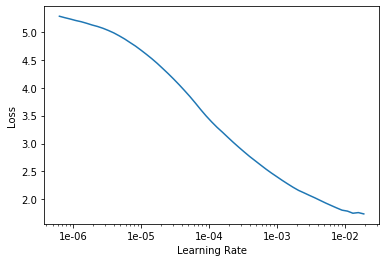

In [79]:
learn2.recorder.plot()

In [80]:
lr=1e-4
learn2.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,1.298839,0.274667,0.440788,01:09
1,0.469908,0.090734,0.579250,01:09
2,0.215429,0.056884,0.620959,01:09
3,0.118549,0.053673,0.635699,01:09


In [81]:
learn2.unfreeze()

In [82]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


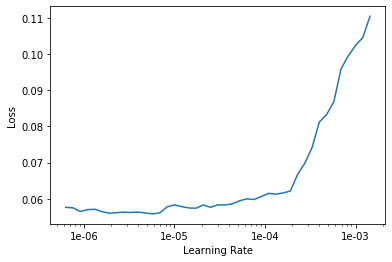

In [83]:
learn2.recorder.plot()

In [84]:
lr=1e-5
learn2.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.057149,0.050500,0.601805,01:10
1,0.052156,0.041572,0.610435,01:11
2,0.044566,0.037093,0.577519,01:11
3,0.040009,0.035505,0.575095,01:11


In [85]:
lr=1e-5
learn2.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.036353,0.034698,0.583551,01:11
1,0.035297,0.035780,0.549766,01:11
2,0.033587,0.028583,0.574664,01:11
3,0.030610,0.026896,0.562046,01:11
4,0.028329,0.027708,0.540057,01:11
5,0.026137,0.024106,0.563609,01:11
6,0.024588,0.023225,0.579279,01:11
7,0.024070,0.023153,0.575971,01:11


In [ ]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
pixel_accuracy(yhat, y):
    

In [121]:
x,y = learn2.data.one_batch()

In [122]:
with torch.no_grad():
    yhat=learn2.model(x.to('cuda'))

In [123]:
yhat.shape, yhat.device, yhat.dtype

(torch.Size([16, 4, 256, 256]), device(type='cuda', index=0), torch.float32)

In [124]:
y.shape, y.device, y.dtype

(torch.Size([16, 1, 256, 256]), device(type='cpu'), torch.int64)

In [125]:
y.squeeze(dim=1).shape

torch.Size([16, 256, 256])

In [126]:
yhat.argmax(dim=1).shape

torch.Size([16, 256, 256])

In [127]:
(y.squeeze(dim=1)==yhat.detach().cpu().argmax(dim=1)).shape

torch.Size([16, 256, 256])

In [128]:
(y.squeeze(dim=1)==yhat.detach().cpu().argmax(dim=1)).sum().float()/y.numel()

tensor(0.9776)

In [130]:
def pixel_accuracy(yhat, y):
    y_ = y.squeeze(dim=1)
    yhat_ = yhat.detach().cpu().argmax(dim=1)
    return (y_==yhat_).sum().float()/y.numel()

In [71]:
learn2.fit(1)

epoch,train_loss,valid_loss,time
0,9224.372070,0.111794,01:14


In [73]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

Yeah, I guess so, cool.